In [26]:
import pandas as pd
import pymysql

from Config.mysqlConfig import community_TB, content_recommend_TB, user_base_TB


def get_register_data(mysql_conn):
    query ="""
SELECT
	`用户id` uid,
	`性别` gender,
	`APP语言` `language`,
	`注册时间` register_time,
	`好友数` friend_num,
	`连接过的产品数` connect_toy_num,
	`国家编码` country_code,
	`渠道` channel 
FROM
	`JHAD_USER`
    """


#     """
#     SELECT
# 	following_user_id,
# 	count(*) numd,
# 	(max( created_at )- min( created_at )) / (3600*24) as total_day,
# 		count(*)/((max( created_at )- min( created_at )) / (3600*24))
# FROM
# 	`follows`
# WHERE
# 	deleted_at = 0
# GROUP BY
# 	following_user_id
# ORDER BY
# 	numd DESC
#     """
    with mysql_conn.cursor() as cursor:
        cursor.execute(query)
        return pd.DataFrame(cursor.fetchall())

def get_post_data(mysql_conn):
    query = "SELECT `id` post_id,`title`,`user_id` author_id,`attachments_count`,`likes_count`,`favorites_count`,`comments_count` FROM `posts`"
    with mysql_conn.cursor() as cursor:
        cursor.execute(query)
        return pd.DataFrame(cursor.fetchall())


def get_post_statistics_data(mysql_conn):
    detail_query = "SELECT `post_id`, `push_number`,`hits_rate`,`like_rate`,`collect_rate`,`comments_rate`,`update_time` FROM `post_score_details` "
    score_query = "SELECT `post_id`,`score` FROM `post_score`"
    with mysql_conn.cursor() as cursor:
        cursor.execute(detail_query)
        detail_df = pd.DataFrame(cursor.fetchall())
        cursor.execute(score_query)
        score_df = pd.DataFrame(cursor.fetchall())

    return detail_df, score_df

def get_act_data(mysql_conn):
    """
    获取用户内容交互数据
    :param mysql_conn:
    :return:
    """
    query = """SELECT `id`,`timestamp`,`uid`,`post_id`,`is_hit`,`is_like`,`stay_duration` FROM `tensorflow_dataset` ORDER BY RAND() LIMIT 5000"""
    with mysql_conn.cursor() as cursor:
        cursor.execute(query)
        act_df = pd.DataFrame(cursor.fetchall())
        content_stats = act_df.groupby('post_id')['is_hit'].agg(['mean', 'count']).rename(
            columns={'mean': 'content_ctr', 'count': 'content_impressions'})
        user_stats = act_df.groupby('uid')['is_hit'].agg(['mean', 'count']).rename(
            columns={'mean': 'user_ctr', 'count': 'user_activity'})
        return act_df,content_stats,user_stats


if __name__ == '__main__':
    community_conn = pymysql.connect(**community_TB,cursorclass=pymysql.cursors.SSDictCursor)     # 社区帖子库
    recommend_conn = pymysql.connect(**content_recommend_TB,cursorclass=pymysql.cursors.SSDictCursor)     # 推荐库
    register_conn = pymysql.connect(**user_base_TB,cursorclass=pymysql.cursors.SSDictCursor)    # 注册库
    with recommend_conn.cursor() as cursor:
        cursor.execute("SET SESSION TRANSACTION ISOLATION LEVEL READ COMMITTED")
    act_df,content_stats,user_stats = get_act_data(recommend_conn)
    detail_df, score_df=get_post_statistics_data(recommend_conn)
    post_df = get_post_data(community_conn)
    register_df = get_register_data(register_conn)

    author_df = register_df.copy()[['uid','language','country_code']]
    author_df.rename(columns={'uid':'author_id','language':'author_language','country_code':'author_country_code'},inplace=True)

    print(act_df.info())
    print(detail_df.info())
    print(post_df.info())
    print(score_df.info())

    print(register_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   id             5000 non-null   int64
 1   timestamp      5000 non-null   int64
 2   uid            5000 non-null   int64
 3   post_id        5000 non-null   int64
 4   is_hit         5000 non-null   int64
 5   is_like        5000 non-null   int64
 6   stay_duration  5000 non-null   int64
dtypes: int64(7)
memory usage: 273.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   post_id        2192 non-null   int64 
 1   push_number    2192 non-null   int64 
 2   hits_rate      2192 non-null   object
 3   like_rate      2192 non-null   object
 4   collect_rate   2192 non-null   object
 5   comments_rate  2192 non-null   object
 6   update_time    2

In [27]:

def fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'int64':
            # 对于int64类型的列，用平均数再取整数填充NaN
            avg_int = int(df[column].mean())
            df.loc[:, column] = df[column].fillna(avg_int)
        elif df[column].dtype == 'object':
            # 对于object类型的列，用出现频率最高的元素填充NaN
            most_frequent = df[column].mode()
            if not most_frequent.empty:
                fill_value = most_frequent[0]
                df.loc[:, column] = df[column].fillna(fill_value)
            else:
                print(f"Warning: Column '{column}' has no mode.")
        elif df[column].dtype == 'float64':
            # 对于float64类型的列，用平均数填充NaN
            avg_float = df[column].mean()
            df.loc[:, column] = df[column].fillna(avg_float)
        elif df[column].dtype == 'datetime64[ns]':
            # 对于datetime64[ns]类型的列，用中位数填充NaN
            median_date = df[column].dropna().median()
            df.loc[:, column] = df[column].fillna(median_date)
        else:
            print(f"Unsupported dtype {df[column].dtype} for column {column}.")
    
    return df


In [28]:
    act_df['timestamp_date'] = pd.to_datetime(act_df['timestamp'], unit='ms')
    act_df['hour'] = act_df['timestamp_date'].dt.hour
    act_df['dow'] = act_df['timestamp_date'].dt.dayofweek

In [29]:
merged_df = act_df.merge(post_df,on='post_id',how='left').merge(detail_df,on='post_id',how='left').merge(score_df,on='post_id',how='left').merge(register_df,on='uid',how='left').merge(author_df,on='author_id',how='left')
merged_df

,id,timestamp,uid,post_id,is_hit,is_like,stay_duration,timestamp_date,hour,dow,...,score,gender,language,register_time,friend_num,connect_toy_num,country_code,channel,author_language,author_country_code
0,6149116,1738601137105,12227251,48,0,0,0,2025-02-03 16:45:37.105,16,0,...,0.45,男,en,2024-05-09 05:09:17,65.0,13.0,IT,3.0,en,CN
1,11359039,1740235571272,16659255,1354,0,0,0,2025-02-22 14:46:11.272,14,5,...,7.12,女,ja,2024-10-02 08:27:30,14.0,3.0,JP,1.0,en,CN
2,1379314,1736698626472,20437336,670,0,0,0,2025-01-12 16:17:06.472,16,6,...,1.34,男,en,2025-01-12 08:06:07,2.0,5.0,IT,1.0,en,CN
3,16664308,1741619133734,20467317,1145,0,0,0,2025-03-10 15:05:33.734,15,0,...,3.35,保密,en,2025-01-22 23:35:28,0.0,3.0,CA,2.0,en,CN
4,7545792,1739115406407,16195063,1091,0,0,0,2025-02-09 15:36:46.407,15,6,...,3.45,男,ja,2024-09-17 22:04:08,1.0,0.0,JP,1.0,en,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16245678,1741509444341,19395920,1716,0,0,0,2025-03-09 08:37:24.341,8,6,...,7.72,男,en,2024-12-15 17:02:04,46.0,1.0,GB,1.0,en,CN
4996,10341634,1739974477613,20478220,1202,0,0,0,2025-02-19 14:14:37.613,14,2,...,5.83,女,en,2025-01-26 22:57:59,2.0,1.0,US,1.0,en,US
4997,3020049,1737333366712,20458781,774,0,0,0,2025-01-20 00:36:06.712,0,0,...,0.83,男,en,2025-01-19 19:02:08,2.0,0.0,CA,1.0,en,US
4998,2727588,1737234183592,19950244,362,0,0,0,2025-01-18 21:03:03.592,21,5,...,0.70,保密,en,2024-12-28 19:08:53,1.0,1.0,US,2.0,en,CN


In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   5000 non-null   int64         
 1   timestamp            5000 non-null   int64         
 2   uid                  5000 non-null   int64         
 3   post_id              5000 non-null   int64         
 4   is_hit               5000 non-null   int64         
 5   is_like              5000 non-null   int64         
 6   stay_duration        5000 non-null   int64         
 7   timestamp_date       5000 non-null   datetime64[ns]
 8   hour                 5000 non-null   int32         
 9   dow                  5000 non-null   int32         
 10  title                5000 non-null   object        
 11  author_id            5000 non-null   int64         
 12  attachments_count    5000 non-null   int64         
 13  likes_count          5000 non-nul

In [31]:
clear_df = fill_missing_values(merged_df)
clear_df

Unsupported dtype int32 for column hour.
Unsupported dtype int32 for column dow.


,id,timestamp,uid,post_id,is_hit,is_like,stay_duration,timestamp_date,hour,dow,...,score,gender,language,register_time,friend_num,connect_toy_num,country_code,channel,author_language,author_country_code
0,6149116,1738601137105,12227251,48,0,0,0,2025-02-03 16:45:37.105,16,0,...,0.45,男,en,2024-05-09 05:09:17,65.0,13.0,IT,3.0,en,CN
1,11359039,1740235571272,16659255,1354,0,0,0,2025-02-22 14:46:11.272,14,5,...,7.12,女,ja,2024-10-02 08:27:30,14.0,3.0,JP,1.0,en,CN
2,1379314,1736698626472,20437336,670,0,0,0,2025-01-12 16:17:06.472,16,6,...,1.34,男,en,2025-01-12 08:06:07,2.0,5.0,IT,1.0,en,CN
3,16664308,1741619133734,20467317,1145,0,0,0,2025-03-10 15:05:33.734,15,0,...,3.35,保密,en,2025-01-22 23:35:28,0.0,3.0,CA,2.0,en,CN
4,7545792,1739115406407,16195063,1091,0,0,0,2025-02-09 15:36:46.407,15,6,...,3.45,男,ja,2024-09-17 22:04:08,1.0,0.0,JP,1.0,en,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,16245678,1741509444341,19395920,1716,0,0,0,2025-03-09 08:37:24.341,8,6,...,7.72,男,en,2024-12-15 17:02:04,46.0,1.0,GB,1.0,en,CN
4996,10341634,1739974477613,20478220,1202,0,0,0,2025-02-19 14:14:37.613,14,2,...,5.83,女,en,2025-01-26 22:57:59,2.0,1.0,US,1.0,en,US
4997,3020049,1737333366712,20458781,774,0,0,0,2025-01-20 00:36:06.712,0,0,...,0.83,男,en,2025-01-19 19:02:08,2.0,0.0,CA,1.0,en,US
4998,2727588,1737234183592,19950244,362,0,0,0,2025-01-18 21:03:03.592,21,5,...,0.70,保密,en,2024-12-28 19:08:53,1.0,1.0,US,2.0,en,CN


In [34]:
clear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   5000 non-null   int64         
 1   timestamp            5000 non-null   int64         
 2   uid                  5000 non-null   int64         
 3   post_id              5000 non-null   int64         
 4   is_hit               5000 non-null   int64         
 5   is_like              5000 non-null   int64         
 6   stay_duration        5000 non-null   int64         
 7   timestamp_date       5000 non-null   datetime64[ns]
 8   hour                 5000 non-null   int32         
 9   dow                  5000 non-null   int32         
 10  title                5000 non-null   object        
 11  author_id            5000 non-null   int64         
 12  attachments_count    5000 non-null   int64         
 13  likes_count          5000 non-nul

In [33]:
clear_df['channel']= clear_df['channel'].astype(int)

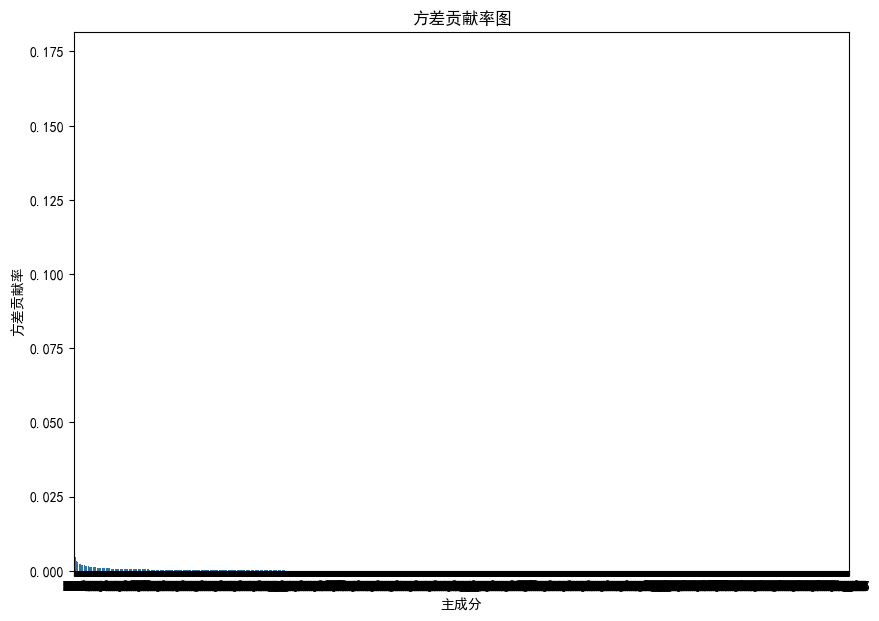

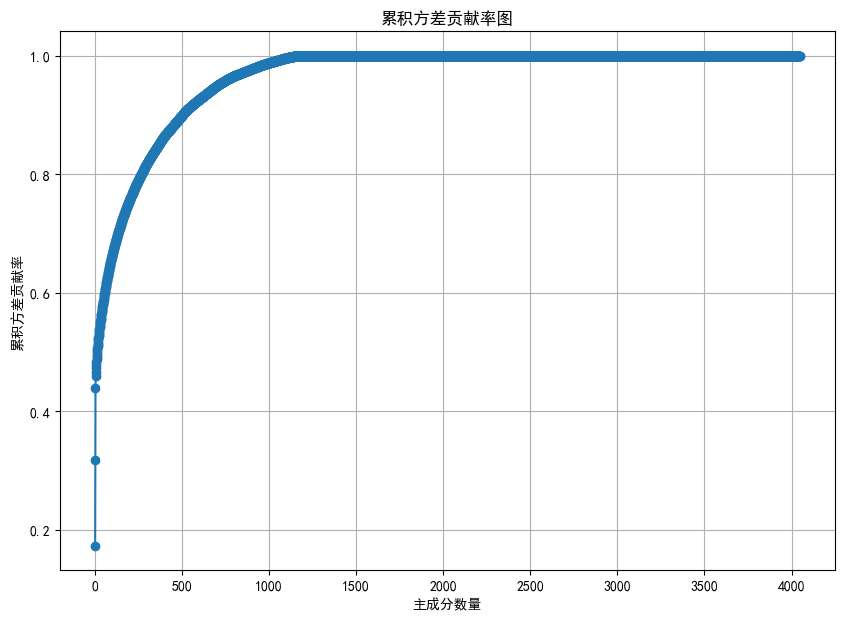

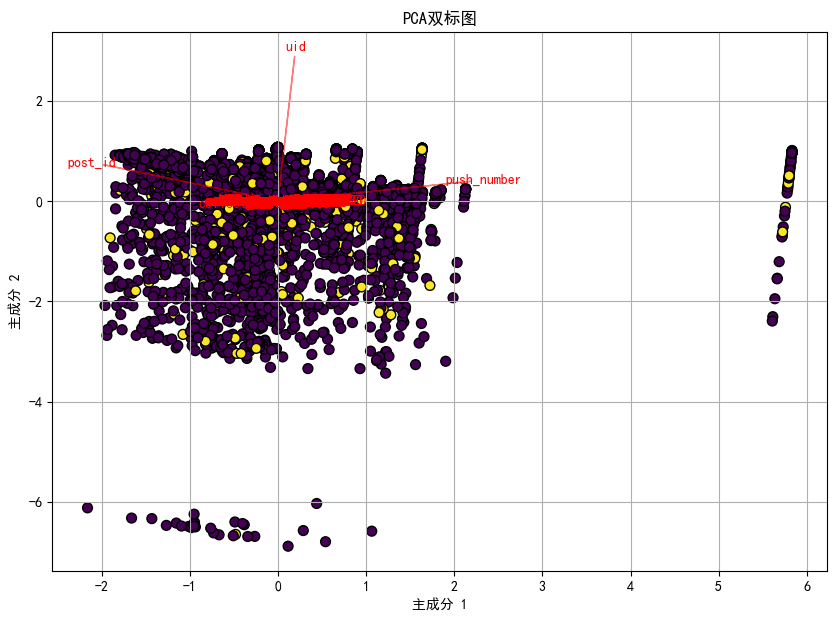

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.4f}'.format  # 设置小数显示4位
plt.rcParams['font.sans-serif'] = 'SimHei'  # 显示中文
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)

# 假设clear_df是你的原始DataFrame
X = clear_df.drop(['is_hit','timestamp_date','register_time','id','timestamp','author_id','title'], axis=1)  # 特征
X = clear_df[['uid','post_id','hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate']]
y = clear_df['is_hit']  # 目标变量

# 分离数值型和非数值型特征
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 创建一个预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

# 应用预处理器并获取特征名称
X_processed = preprocessor.fit_transform(X)

# 获取one-hot编码后的特征名称
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

# 应用PCA进行降维
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# 方差贡献率图
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(10, 7))
sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance_ratio))], y=explained_variance_ratio)
plt.title('方差贡献率图')
plt.xlabel('主成分')
plt.ylabel('方差贡献率')
plt.show()

# 累积方差贡献率图
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker='o')
plt.title('累积方差贡献率图')
plt.xlabel('主成分数量')
plt.ylabel('累积方差贡献率')
plt.grid(True)
plt.show()

# PCA双标图（这里只展示前两个主成分）
pca_final = PCA(n_components=2)
X_pca_final = pca_final.fit_transform(X_processed)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA双标图')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')

# 显示原始变量的方向
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, pca_final.components_[0, i]*3, pca_final.components_[1, i]*3,
              color='r', alpha=0.5)
    plt.text(pca_final.components_[0, i]*3.2, pca_final.components_[1, i]*3.2, feature,
             color='r', ha='center', va='center')

plt.grid(True)
plt.show()

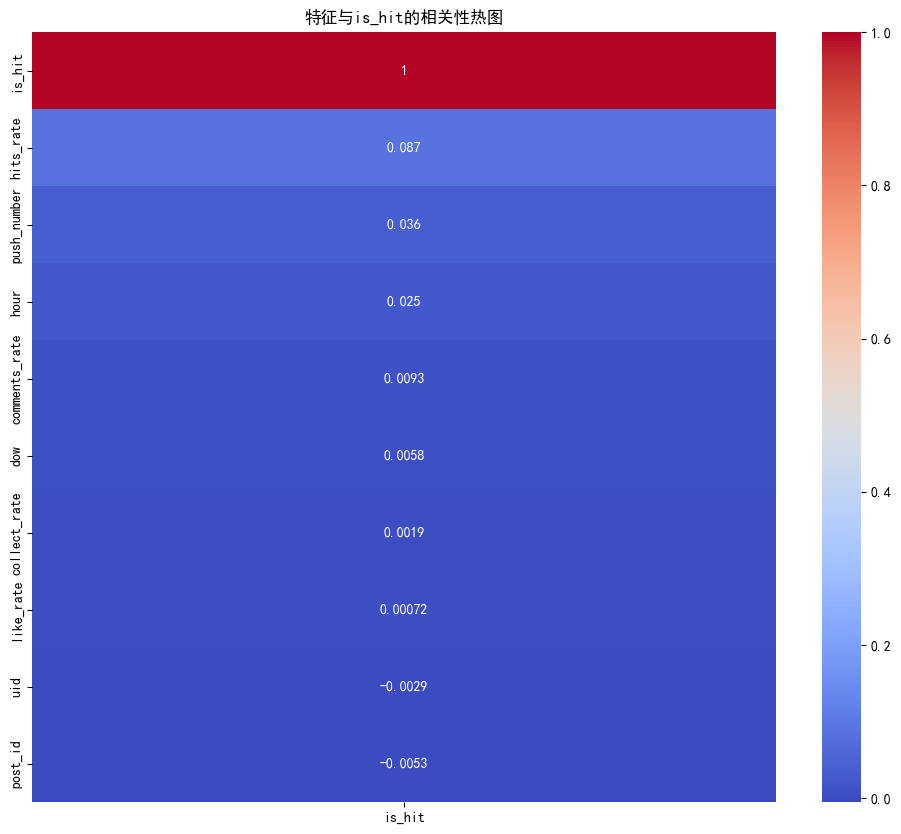

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关矩阵
correlation_matrix = clear_df[['uid','post_id','hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate','is_hit']].corr()

# 绘制热图
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['is_hit']].sort_values(by='is_hit', ascending=False), annot=True, cmap='coolwarm')
plt.title('特征与is_hit的相关性热图')
plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# 准备数据
clear_df[['hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate']] = clear_df[['hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate']].astype(float)
X = clear_df[['hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate']]
y = clear_df['is_hit']


# 构建并训练随机森林模型
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# 获取特征重要性
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# 绘制特征重要性图
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_processed.shape[1]), importances[indices], align="center")
plt.xticks(range(X_processed.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_processed.shape[1]])
plt.tight_layout()
plt.show()

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [55]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设df是你的DataFrame
# df = pd.read_csv('your_data_source.csv')  # 如果需要从文件加载数据，请取消此行注释

# 分离特征和目标变量
X = clear_df[['hour','dow','push_number','hits_rate','like_rate','collect_rate','comments_rate']].astype(float)
y = clear_df['is_hit']  # 目标变量

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 应用PCA
pca = PCA()  # 如果你知道要保留的主成分数，可以在这里指定n_components参数
X_pca = pca.fit_transform(X_scaled)

# 查看每个主成分解释的方差比例，以决定保留多少个主成分
explained_variance_ratio = pca.explained_variance_ratio_
print("每个主成分解释的方差比例：", explained_variance_ratio)

# 根据解释方差决定保留的主成分数，例如选择累积贡献率大于80%的主成分数量
cumulative_explained_variance = explained_variance_ratio.cumsum()
desired_variance_ratio = 0.8  # 这里设置你希望保留的方差比例
num_components = next(i for i, v in enumerate(cumulative_explained_variance) if v > desired_variance_ratio) + 1
print(f"为了达到{desired_variance_ratio * 100}%的方差解释度，需要保留{num_components}个主成分")

# 使用确定数量的主成分再次应用PCA
pca_final = PCA(n_components=num_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# 将降维后的数据转换回DataFrame，并添加目标变量
df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(num_components)])
df_pca['is_hit'] = y.values

print(df_pca.head())

每个主成分解释的方差比例： [0.25299847 0.15335801 0.14599711 0.14258692 0.1395555  0.09101783
 0.07448617]
为了达到80.0%的方差解释度，需要保留5个主成分
      PC1     PC2     PC3     PC4     PC5  is_hit
0 -0.2400  0.7802 -0.6567  0.4820  1.2326       0
1 -0.4401 -0.7795  0.6639 -0.5660 -0.2435       0
2 -0.0374 -0.3746  1.3558 -0.5334 -0.4406       0
3 -0.2373 -0.0517 -0.9660 -0.4711  1.3344       0
4  0.6041  1.0800  1.5075 -0.5168 -0.7980       0
